In [1]:
!pip install langchain langgraph langchain_community langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.19
    Uninstalling langchain-core-0.3.19:
      Successfully uninstalled langchain-core-0.3.19
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.7
    Uninstalling langchain-0.3.7:
      Successfully uninstalled langchain-0.3.7


In [2]:
!pip install tiktoken


In [27]:
import os
from google.colab import userdata
openai_api_key=userdata.get('openai_api_key')
os.environ["OPENAI_API_KEY"] = openai_api_key

In [28]:
from langchain_community.document_loaders import PyPDFLoader

def get_documents_from_pdf(filepath):
    pdf_files = [filepath]

    all_pages = []
    for pdf_file in pdf_files:
        loader = PyPDFLoader(pdf_file)  # Use the variable pdf_file directly
        pages = loader.load_and_split()
        all_pages.extend(pages)

    return all_pages


In [29]:
!pip install Chromadb
!pip install pypdf
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

vectorStore = Chroma.from_documents(
    documents=get_documents_from_pdf("/Resume.pdf"),
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)


In [30]:
retriever=vectorStore.as_retriever(search_kwargs={"k": 3})

In [31]:
print(retriever.invoke("Who is Tushar Panchal",ConsistencyLevel="LOCAL_ONE"))

[Document(metadata={'page': 0, 'source': '/Resume.pdf'}, page_content='TUSHARVASANTPANCHAL\nPh:7816545189 tpanchal21@gmail.com Loc:Mechanicsburg,PA JobAuth:Greencard\nSnapshotofSkillsandKeyAchievements:\n● Havealmost20+yearsofconsiderableexposuretoallstagesofSDLC,Agilesoftwaredevelopment,Techplanning,Automatedtesting,Observability,Devopsintegrationetc.● ConsiderableExperienceinextensivePythoncomponent,javaspringbootmicroservicesdevelopment,deploymenttoAWS,maintainingC#.NETlegacyappsetc.● ExtensiveexperiencewithAWStechnologies,includingAWSLambda(Python),S3,EC2,CloudFormation,Opensearch,DynamoDB,AuroraDB,andIAMrolesANDcostoptimization.● Ledthesuccessfuldesign,development,anddeploymentofadvancedGenAItechnologies(LLMs)i.eAnthropic’sClaudeusingAWSBedrock,MachineLearningModelCoherererankviaAWSSageMaker,AzureChatGPTAPI,OpenAIGPTCoherererankapietc.significantlyenhancingtheorganization’sNLPcapabilities.● SuccessfullyintegratedAWSTranslationAPIsenablingrobustlocalizationcapabilities.● Experience

In [43]:
from langchain_openai import ChatOpenAI

def retrieve(state):
    llm = ChatOpenAI(
            model="gpt-3.5-turbo-1106",
            temperature=0.4
        )
    from operator import itemgetter
    from langchain_core.prompts import ChatPromptTemplate
    prompt = ChatPromptTemplate.from_template("""
    Answer the following question based only on the provided context.
    Think step by step before providing a detailed answer.
    <context>
    {context}
    </context>

    Question: {input}""")
    question = state["question"]
    from langchain.chains import create_retrieval_chain
    from langchain.chains.combine_documents import create_stuff_documents_chain

    retriever=vectorStore.as_retriever()
    document_chain=create_stuff_documents_chain(llm,prompt)
    retrieval_chain=create_retrieval_chain(retriever,document_chain)

    response = retrieval_chain.invoke({"input": question})
    return {"documents": response['answer'], "question": response['input']}

In [33]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field



# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )

from google.colab import userdata
# LLM with function call
from langchain_openai import ChatOpenAI
import os
#groq_api_key=userdata.get('groq_api_key')
#os.environ["GROQ_API_KEY"]=groq_api_key
llm = ChatOpenAI(
        model="gpt-3.5-turbo-1106",
        temperature=0.4
    )
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to Tushar Panchal and his skills and professional experiances.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "who is Tushar?"}
    )
)
print(question_router.invoke({"question": "who is Sharukh Khan?"}))

datasource='vectorstore'
datasource='wiki_search'


In [34]:
!pip install langchain_community
!pip install arxiv wikipedia

In [35]:
### Working With Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv and wikipedia Tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [36]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [37]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [38]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [39]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

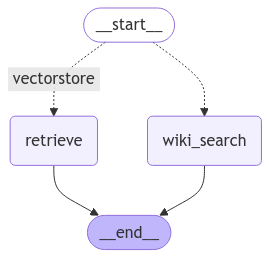

In [40]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [45]:
from pprint import pprint

# Run
inputs = {
    "question": "Tell me about Tushar Panchal's company in year 2002?"
}
for output in app.stream(

    inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
print(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
"Node 'retrieve':"
'\n---\n'
Based on the provided context, Tushar Panchal was working as a Senior Software Programmer at CoxandKingsPvtLtd in India from December 2001 to August 2003. In this role, he was responsible for designing, developing, and implementing a B2B intranet system and computerized leisure operations across multiple offices. He played a key role in system analysis, database design, and infrastructure setup, while overseeing development and testing teams. Additionally, he led critical coding efforts and delivered business presentations and user training on the new systems.


In [21]:
from pprint import pprint

# Run
inputs = {
    "question": "who won the presidential election for year 2024?"
}
for output in app.stream(

    inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'].page_content)

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
who won the presidential election for year 2024?
"Node 'wiki_search':"
'\n---\n'
('Page: 2024 United States presidential election\n'
 'Summary: Presidential elections were held in the United States on November '
 "5, 2024. The Republican Party's ticket—Donald Trump, who was the 45th "
 'presiden')
